# Basic RNN - Recurrent Neural Networks
Up to now we've used neural networks to classify static images. What happens when the thing we're trying to explain changes over time? What if a predicted value depends on a series of past behaviors?

We can train networks to tell us that an image contains a car.<br>

How do we answer the question "Is the car moving? Where will it be a minute from now?"

This challenge of incorporating a series of measurements over time into the model parameters is addressed by <a href='https://en.wikipedia.org/wiki/Recurrent_neural_network'>Recurrent Neural Networks</a> (RNNs).

Be sure to watch the theory lectures. You should be comfortable with:
* conditional memory
* deep sequence modeling
* vanishing gradients
* gated cells
* long short-term memory (LSTM) cells

PyTorch offers a number of RNN layers and options.<br>
* <a href='https://pytorch.org/docs/stable/nn.html#rnn'><tt><strong>torch.nn.RNN()</strong></tt></a> provides a basic model which applies a multilayer RNN with either <em>tanh</em> or <em>ReLU</em> non-linearity functions to an input sequence.<br>
As we learned in the theory lectures, however, this has its limits.<br><br>
* <a href='https://pytorch.org/docs/stable/nn.html#lstm'><tt><strong>torch.nn.LSTM()</strong></tt></a> adds a multi-layer long short-term memory (LSTM) process which greatly extends the memory of the RNN.

## Advantages of an LSTM
For each element in the input sequence, an LSTM layer computes the following functions:<br>
$\begin{array}{ll} \\
    i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
    f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
    g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
    o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
    c_t = f_t * c_{(t-1)} + i_t * g_t \\
    h_t = o_t * \tanh(c_t) \\
\end{array}$

where $h_t$ is the hidden state at time $t$, <br>
$c_t$ is the cell state at time $t$, <br>
$x_t$ is the input at time $t$, <br>
$h_{(t-1)}$ is the hidden state of the layer at time $t-1$ or the initial hidden state at time $0$, and <br>
$i_t, f_t, g_t, o_t$ are the input, forget, cell, and output gates, respectively.<br>
$\sigma$ is the sigmoid function, and $*$ is the Hadamard product.

<img style="display: inline-block" src="../Images/LSTM-graphic.png" alt="LSTM Graphic" width="500">

To demonstrate the potential of LSTMs, we'll look at a simple sine wave. Our goal is, given a value, predict the next value in the sequence. Due to the cyclical nature of sine waves, an typical neural network won't know if it should predict upward or downward, while an LSTM is capable of learning patterns of values.

## Perform standard imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Create a sine wave dataset
For this exercise we'll look at a simple sine wave. We'll take 800 data points and assign 40 points per full cycle, for a total of 20 complete cycles. We'll train our model on all but the last cycle, and use that to evaluate our test predictions.

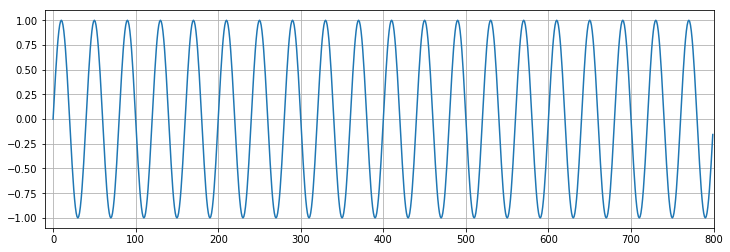

In [2]:
# Create & plot data points
x = torch.linspace(0,799,steps=800)
y = torch.sin(x*2*3.1416/40)

plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(y.numpy());

## Create train and test sets
We want to take the first 760 samples in our series as a training sequence, and the last 40 for testing.
<div class="alert alert-info"><strong>NOTE:</strong> We tend to use the terms "series" and "sequence" interchangeably. Usually "series" refers to the entire population of data, or the full time series, and "sequence" refers to some portion of it.</div>

In [3]:
test_size = 40

train_set = y[:-test_size]
test_set = y[-test_size:]

## Prepare the training data
When working with LSTM models, we start by dividing the training sequence into a series of overlapping "windows". Each window consists of a connected string of samples. The label used for comparison is equal to the next value in the sequence. In this way our network learns what value should follow a given pattern of preceding values. Note: although the LSTM layer produces a prediction for each sample in the window, we only care about the last one.

For example, say we have a series of 15 records, and a window size of 5. We feed $[x_1,..,x_5]$ into the model, and compare the prediction to $x_6$. Then we backprop, update parameters, and feed $[x_2,..,x_6]$ into the model. We compare the new output to $x_7$ and so forth up to $[x_{10},..,x_{14}]$.

To simplify matters, we'll define a function called <tt>input_data</tt> that builds a list of <tt>(seq, label)</tt> tuples. Windows overlap, so the first tuple might contain $([x_1,..,x_5],[x_6])$, the second would have $([x_2,..,x_6],[x_7])$, etc. 

Here $k$ is the width of the window. Due to the overlap, we'll have a total number of <tt>(seq, label)</tt> tuples equal to $\textrm{len}(series)-k$

In [4]:
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

<div class="alert alert-info"><strong>NOTE:</strong> "Windows" are different from "batches". In our example we'll feed one window into the model at a time, so our batch size would be 1. If we passed two windows into the model before we backprop and update weights, our batch size would be 2.</div>

To train on our sine wave data we'll use a window size of 40 (one entire cycle). 

In [5]:
# From above:
# test_size = 40
# train_set = y[:-test_size]
# test_set = y[-test_size:]

window_size = 40

# Create the training dataset of sequence/label tuples:
train_data = input_data(train_set,window_size)

len(train_data) # this should equal 760-40

720

In [6]:
# Display the first (seq/label) tuple in train_data
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

In [7]:
torch.set_printoptions(sci_mode=False) # to improve the appearance of tensors
train_data[0]

(tensor([     0.0000,      0.1564,      0.3090,      0.4540,      0.5878,
              0.7071,      0.8090,      0.8910,      0.9511,      0.9877,
              1.0000,      0.9877,      0.9511,      0.8910,      0.8090,
              0.7071,      0.5878,      0.4540,      0.3090,      0.1564,
             -0.0000,     -0.1564,     -0.3090,     -0.4540,     -0.5878,
             -0.7071,     -0.8090,     -0.8910,     -0.9511,     -0.9877,
             -1.0000,     -0.9877,     -0.9511,     -0.8910,     -0.8090,
             -0.7071,     -0.5878,     -0.4540,     -0.3090,     -0.1564]),
 tensor([    0.0000]))

## Define an LSTM model
Our model will have one LSTM layer with an input size of 1 and a hidden size of 50, followed by a fully-connected layer to reduce the output to the prediction size of 1.<br>
<div class="alert alert-info"><strong>NOTE:</strong> You will often see the terms <em>input_dim</em> and <em> hidden_dim</em> used in place of <em>input_size</em> and <em>hidden_size</em>. They mean the same thing. We'll stick to <em>input_size</em> and <em>hidden_size</em> to stay consistent with PyTorch's built-in keywords.</div>

During training we pass three tensors through the LSTM layer - the sequence, the hidden state $h_0$ and the cell state $c_0$.<br>

This means we need to initialize $h_0$ and $c_0$. This can be done with random values, but we'll use zeros instead.

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,out_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,hidden_size),
                       torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]   # we only care about the last prediction

## Instantiate the model, define loss & optimization functions
Since we're comparing single values, we'll use <a href='https://pytorch.org/docs/stable/nn.html#mseloss'><tt><strong>torch.nn.MSELoss</strong></tt></a><br>Also, we've found that <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.SGD'><tt><strong>torch.optim.SGD</strong></tt></a> converges faster for this application than <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><tt><strong>torch.optim.Adam</strong></tt></a>

In [9]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [10]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   200
 10000
   200
   200
    50
     1
______
 10651


## Predicting future values
To show how an LSTM model improves after each epoch, we'll run predictions and plot the results. Our goal is to predict the last sequence of 40 values, and compare them to the known data in our test set. However, we have to be careful <em>not</em> to use test data in the predictions - that is, each new prediction derives from previously predicted values.

The trick is to take the last known window, predict the next value, then <em>append</em> the predicted value to the sequence and run a new prediction on a window that includes the value we've just predicted. It's like adding track in front of the train as it's moving.<br><em>Image source:</em> https://giphy.com/gifs/aardman-cartoon-train-3oz8xtBx06mcZWoNJm<br>
<img style="display: inline-block" src="../Images/WallaceGromitTrainTrack.gif" alt="Wallace & Gromit" width="400">

In this way, a well-trained model <em>should</em> follow any regular trends/cycles in the data.

## Train and simultaneously evaluate the model
We'll train 10 epochs. For clarity, we'll "zoom in" on the test set, and only display from point 700 to the end.

Epoch:  1 Loss: 0.09212875
Loss on test predictions: 0.6071590185165405


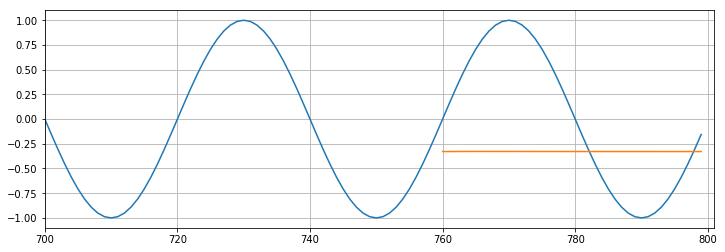

Epoch:  2 Loss: 0.06506767
Loss on test predictions: 0.565098762512207


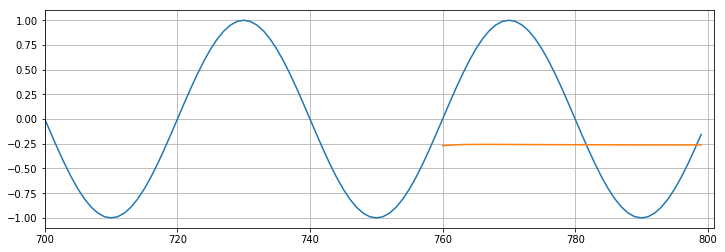

Epoch:  3 Loss: 0.04198047
Loss on test predictions: 0.5199716687202454


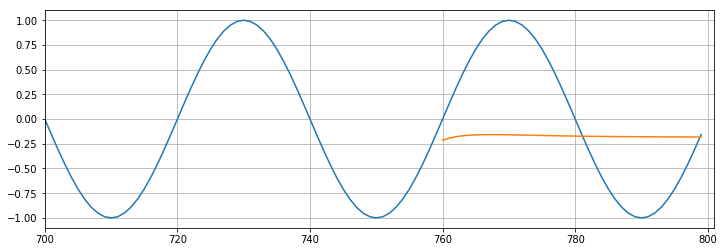

Epoch:  4 Loss: 0.01784276
Loss on test predictions: 0.42209967970848083


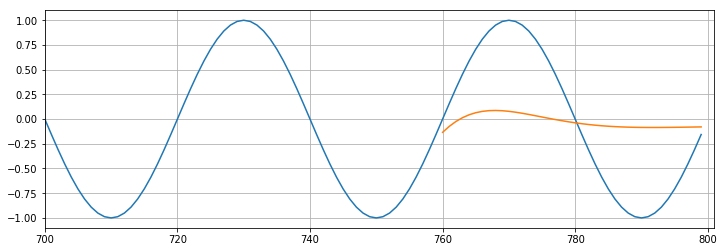

Epoch:  5 Loss: 0.00288710
Loss on test predictions: 0.16624116897583008


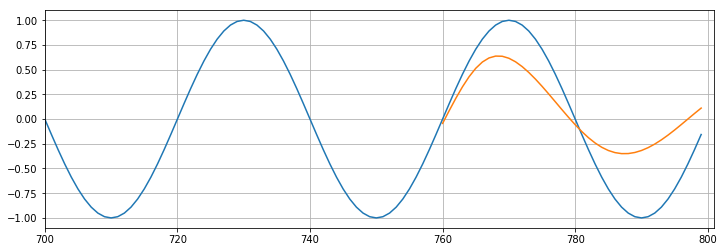

Epoch:  6 Loss: 0.00032008
Loss on test predictions: 0.03055439703166485


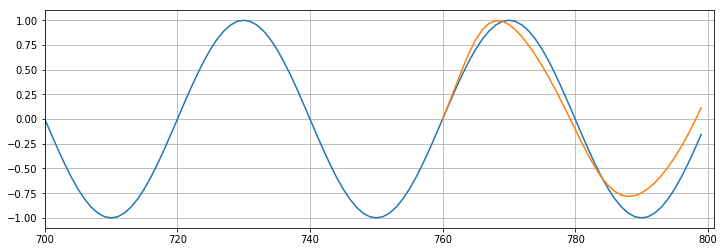

Epoch:  7 Loss: 0.00012969
Loss on test predictions: 0.014990181662142277


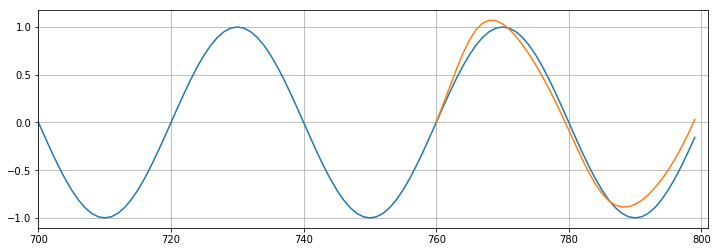

Epoch:  8 Loss: 0.00012007
Loss on test predictions: 0.011856676079332829


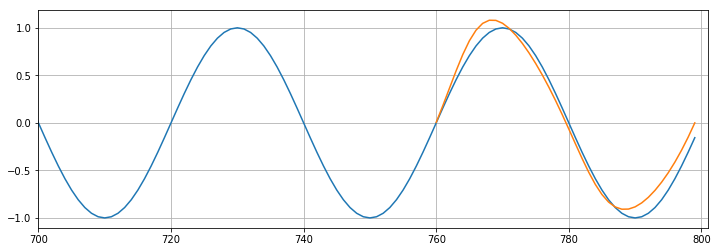

Epoch:  9 Loss: 0.00012656
Loss on test predictions: 0.010163827799260616


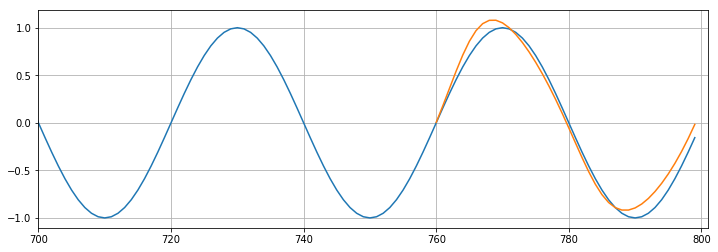

Epoch: 10 Loss: 0.00013195
Loss on test predictions: 0.00889757089316845


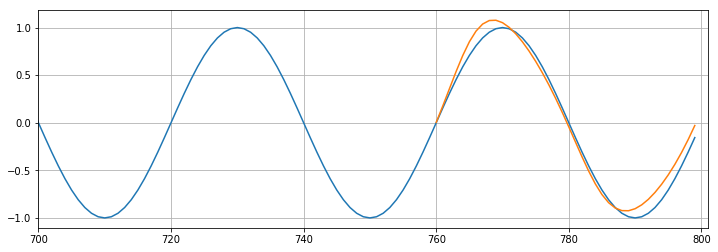

In [11]:
epochs = 10
future = 40

for i in range(epochs):
    
    # tuple-unpack the train_data set
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')
    
    # MAKE PREDICTIONS
    # start with a list of the last 10 training records
    preds = train_set[-window_size:].tolist()

    for f in range(future):  
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
            
    loss = criterion(torch.tensor(preds[-window_size:]),y[760:])
    print(f'Loss on test predictions: {loss}')

    # Plot from point 700 to the end
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800),preds[window_size:])
    plt.show()

# Forecasting into an unknown future
We'll continue to train our model, this time using the entire dataset. Then we'll predict what the <em>next</em> 40 points should be.

## Train the model
Expect this to take a few minutes.

In [12]:
epochs = 10
window_size = 40
future = 40

# Create the full set of sequence/label tuples:
all_data = input_data(y,window_size)
len(all_data)  # this should equal 800-40

760

In [13]:
import time
start_time = time.time()

for i in range(epochs):
    
    # tuple-unpack the entire set of data
    for seq, y_train in all_data:  
       
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00013453
Epoch:  2 Loss: 0.00013443
Epoch:  3 Loss: 0.00013232
Epoch:  4 Loss: 0.00012879
Epoch:  5 Loss: 0.00012434
Epoch:  6 Loss: 0.00011931
Epoch:  7 Loss: 0.00011398
Epoch:  8 Loss: 0.00010854
Epoch:  9 Loss: 0.00010313
Epoch: 10 Loss: 0.00009784

Duration: 173 seconds


## Predict future values, plot the result

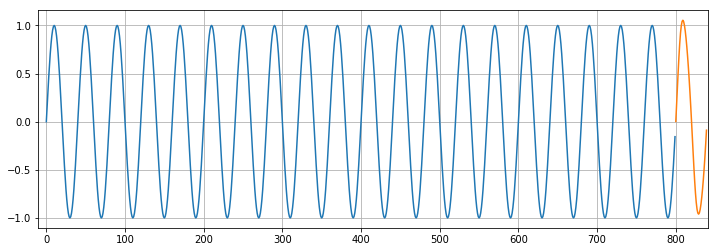

In [14]:
preds = y[-window_size:].tolist()

for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

plt.figure(figsize=(12,4))
plt.xlim(-10,841)
plt.grid(True)
plt.plot(y.numpy())
plt.plot(range(800,800+future),preds[window_size:])
plt.show()

## Great job!

<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# RNN on a Time Series
For these examples we're using data from the Federal Reserve Economic Database (FRED) concerning Sales of Beer, Wine, and Distilled Alcoholic Beverages in millions of dollars from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/S4248SM144NCEN

## Perform standard imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load the dataset
We'll take advantage of pandas' built-in <a href='https://pandas.pydata.org/pandas-docs/stable/timeseries.html'>DatetimeIndex</a> by passing <tt>parse_dates=True</tt>

In [2]:
df = pd.read_csv('../Data/TimeSeriesData/Alcohol_Sales.csv',index_col=0,parse_dates=True)
len(df)

325

In [3]:
# Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

325

In [4]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
df.tail()

,S4248SM144NCEN
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


## Plotting time series data
We can add titles, axis labels, and other features to the plot.<br>
We're going to tighten the x-axis to fit the width of the actual data with <tt>plt.autoscale(axis='x',tight=True)</tt>.<br>
Alternatively you could set your own limits with <tt>plt.xlim(pd.Timestamp('1992-01-01'), pd.Timestamp('2019-01-01'))</tt> or some other values.

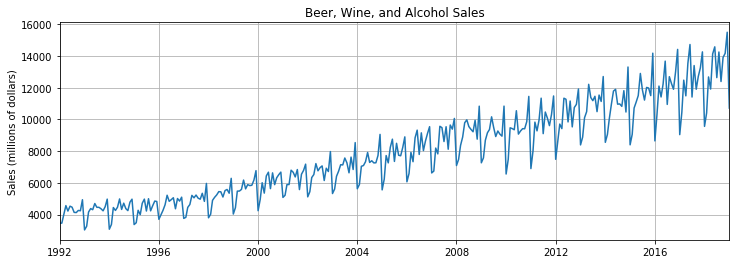

In [6]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Prepare the data
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [7]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [8]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

It's worth noting that in our previous exercise the train and test sets were tensors. Here they're numpy arrays. This is because one of the steps we're about to perform outputs an array, and we'd have to turn it into a tensor anyway.

## Normalize the data
The formula for normalizing data around zero is:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the population mean, and $\sigma$ is the population standard deviation.<br>
Recall that back in the CNN section we transformed image files using <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt><strong>torchvision.transforms.Normalize(<em>mean, std</em>)</strong></tt></a>, both because it was built into DataLoader, and because our pretrained models expected specific normalization values.<br>

Ultimately we want to perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> so that our values fall between -1 and 1, as this makes hyperparameters converge faster.<br>The formula for this would be:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$<br>

We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

NOTE: We only want to normalize the training set to avoid data leakage. If we include the test set then the higher average values of the test set could become part of the signal in the training set. There's a good article on data leakage <a href='test_set = input_data(test_norm,window_size)'>here</a>.

After using transformed data to train the model and generate predictions, we'll inverse_transform the predicted values so that we can compare them to the actual test data.

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [10]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [11]:
train_norm.min()

-1.0

In [12]:
train_norm.max()

1.0

In [13]:
train_norm.mean()

-0.2041940178388313

In [14]:
type(train_norm)

numpy.ndarray

## Prepare data for LSTM
Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [15]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

301

In [16]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]), tensor([-1.]))

## Define the model
This time we'll use an LSTM layer of size (1,100).

In [17]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

## Instantiate the model, define loss and optimization functions

In [18]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [19]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


## Train the model

In [20]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.25314346
Epoch:  2 Loss: 0.37523878
Epoch:  3 Loss: 0.39012098
Epoch:  4 Loss: 0.34949699
Epoch:  5 Loss: 0.33077896
Epoch:  6 Loss: 0.33230731
Epoch:  7 Loss: 0.32667691
Epoch:  8 Loss: 0.32077038
Epoch:  9 Loss: 0.30651760
Epoch: 10 Loss: 0.29517019
Epoch: 11 Loss: 0.26913935
Epoch: 12 Loss: 0.25979361
Epoch: 13 Loss: 0.24600053
Epoch: 14 Loss: 0.22227803
Epoch: 15 Loss: 0.18593730
Epoch: 16 Loss: 0.18445705
Epoch: 17 Loss: 0.17432655
Epoch: 18 Loss: 0.25822312
Epoch: 19 Loss: 0.22420478
Epoch: 20 Loss: 0.23121868
Epoch: 21 Loss: 0.19758533
Epoch: 22 Loss: 0.18988022
Epoch: 23 Loss: 0.21032184
Epoch: 24 Loss: 0.16950732
Epoch: 25 Loss: 0.14586549
Epoch: 26 Loss: 0.11828811
Epoch: 27 Loss: 0.00027535
Epoch: 28 Loss: 0.00681852
Epoch: 29 Loss: 0.05630350
Epoch: 30 Loss: 0.01223376
Epoch: 31 Loss: 0.02709176
Epoch: 32 Loss: 0.03447094
Epoch: 33 Loss: 0.02249899
Epoch: 34 Loss: 0.01159327
Epoch: 35 Loss: 0.01592799
Epoch: 36 Loss: 0.00303702
Epoch: 37 Loss: 0.00015524
E

## Run predictions and compare to known test set

In [21]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [22]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.3245275914669037,
 0.5227924585342407,
 0.5454435348510742,
 0.8364425301551819,
 1.104264736175537,
 0.30810344219207764,
 0.8207511901855469,
 0.5576714873313904,
 0.5653725862503052,
 0.8198413848876953,
 0.9293676018714905,
 0.12615284323692322]

## Invert the normalization
We want to compare our test predictions to the original data, so we need to undo the previous normalization step. Note that <tt>inverse_transform</tt> uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [23]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[10778.82414629],
       [11938.5744862 ],
       [12071.07195711],
       [13773.27058014],
       [15339.89657426],
       [10682.7510851 ],
       [13681.48408699],
       [12142.59936514],
       [12187.64694327],
       [13676.1621809 ],
       [14316.83578715],
       [ 9618.43105651]])

In [24]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

It looks like our predictions weren't that far off!
## Plot the results
Our original data contains a datetime index, but our predicted values do not. We can create a range of dates using NumPy that are spaced one month apart using <tt>dtype='datetime64[M]'</tt>, and then store them with day values to match our dataset with <tt>.astype('datetime64[D]')</tt>.

In [25]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

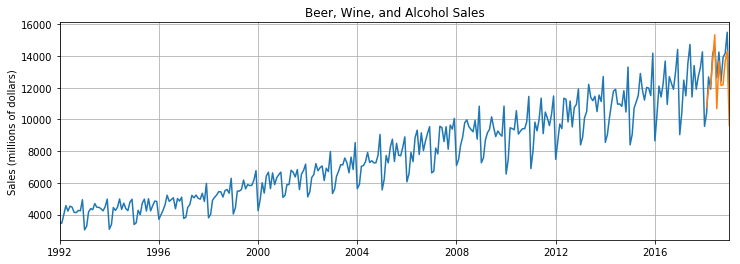

In [26]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

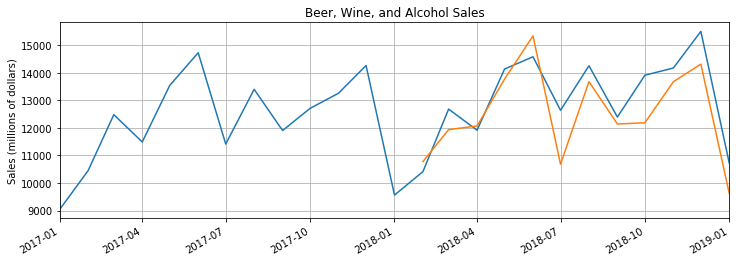

In [27]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

For more information on x-axis date formatting in matplotlib, check out <a href='https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.autofmt_xdate'><tt><strong>matplotlib.figure.Figure.autofmt_xdate</strong></tt></a> and <a href='https://matplotlib.org/api/dates_api.html#matplotlib.dates.DateFormatter'><tt><strong>matplotlib.dates.DateFormatter</strong></tt></a>

# Forecast into an unknown future
This time we'll continue training the model using the entire dataset, and predict 12 steps into the future.

In [28]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.02658496
Epoch:  2 Loss: 0.02985313
Epoch:  3 Loss: 0.01421225
Epoch:  4 Loss: 0.01419733
Epoch:  5 Loss: 0.01290122
Epoch:  6 Loss: 0.01244991
Epoch:  7 Loss: 0.01119690
Epoch:  8 Loss: 0.00854800
Epoch:  9 Loss: 0.00788417
Epoch: 10 Loss: 0.00792318
Epoch: 11 Loss: 0.00556064
Epoch: 12 Loss: 0.00598394
Epoch: 13 Loss: 0.00537636
Epoch: 14 Loss: 0.00649350
Epoch: 15 Loss: 0.00798889
Epoch: 16 Loss: 0.00699036
Epoch: 17 Loss: 0.00741554
Epoch: 18 Loss: 0.00671443
Epoch: 19 Loss: 0.00555703
Epoch: 20 Loss: 0.00517232
Epoch: 21 Loss: 0.00519288
Epoch: 22 Loss: 0.00412102
Epoch: 23 Loss: 0.00535119
Epoch: 24 Loss: 0.00888540
Epoch: 25 Loss: 0.00753472
Epoch: 26 Loss: 0.00589289
Epoch: 27 Loss: 0.00580891
Epoch: 28 Loss: 0.00776316
Epoch: 29 Loss: 0.00629479
Epoch: 30 Loss: 0.00895946
Epoch: 31 Loss: 0.00883982
Epoch: 32 Loss: 0.00968022
Epoch: 33 Loss: 0.00415197
Epoch: 34 Loss: 0.00383917
Epoch: 35 Loss: 0.00253066
Epoch: 36 Loss: 0.00149691
Epoch: 37 Loss: 0.00340568
E

## Predict future values, plot the result

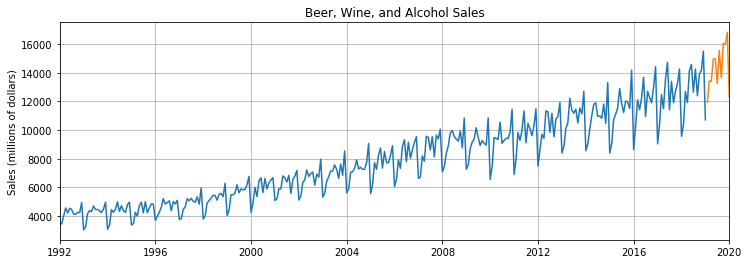

In [29]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

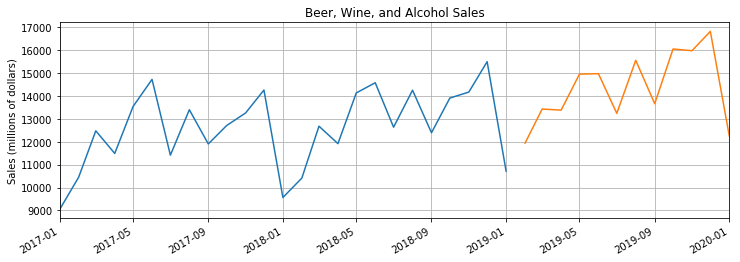

In [30]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()

## Great job!

<h3>BONUS:</h3>To save time in the future, we've written a function that will take in a time series training data set, and output a tensor of <tt>(seq, label)</tt> tuples.

In [31]:
# Load dependencies
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler
"""
This has to be done outside the function definition so that
we can inverse_transform the prediction set later on.
"""
scaler = MinMaxScaler(feature_range=(-1, 1))

# Extract values from the source .csv file
df = pd.read_csv('../Data/TimeSeriesData/Alcohol_Sales.csv',index_col=0,parse_dates=True)
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create the training set of values
train_set = y[:-test_size]

In [32]:
# DEFINE A FUNCTION:
def create_train_data(seq,ws=12):
    """Takes in a training sequence and window size (ws) of
       default size 12, returns a tensor of (seq/label) tuples"""
    seq_norm = scaler.fit_transform(seq.reshape(-1, 1))    
    seq_norm = torch.FloatTensor(seq_norm).view(-1)

    out = []
    L = len(seq_norm)
    for i in range(L-ws):
        window = seq_norm[i:i+ws]
        label = seq_norm[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [33]:
# Apply the function to train_set
train_data = create_train_data(train_set,12)
len(train_data)  # this should equal 313-12

301

In [34]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]), tensor([-1.]))

In [35]:
help(create_train_data)

Help on function create_train_data in module __main__:

create_train_data(seq, ws=12)
    Takes in a training sequence and window size (ws) of
    default size 12, returns a tensor of (seq/label) tuples



<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# RNN Exercises
For these exercises we're using data from the Federal Reserve Economic Database (FRED) concerning Electricity and Gas Utilities Production from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/IPG2211A2N

In the exercises below you'll be asked to do the following:
* Perform standard imports, load & plot the dataset (code provided)
* Prepare data for an LSTM model
* Define the LSTM model, loss and optimization functions
* Train the model
* Evaluate the model on test data
* OPTIONAL: Plot the results

<div class="alert alert-danger" style="margin: 10px"><strong>IMPORTANT NOTE!</strong> Make sure you don't run the cells directly above the example output shown, <br>otherwise you will end up writing over the example output!</div>

## Perform standard imports, load and plot the dataset
Run the cells below to load the libraries needed for this exercise and the Energy Production dataset, and to plot the data.

In [1]:
# RUN THIS CELL
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('../Data/TimeSeriesData/Energy_Production.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head()

325


,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


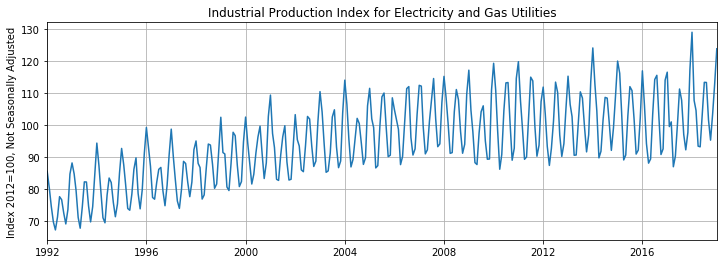

In [2]:
# RUN THIS CELL
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

# Prepare the data
For the first set of exercises we'll
* divide the data into train and test sets
* normalize the training set
* prepare windowed seq/label tuples for an LSTM model

## 1. Divide the data into train and test sets
Working with a window_size of 12, divide the dataset into a sequence of 313 training records (including the window), and a test set of 12 records.

In [ ]:
# CODE HERE
y = df['IPG2211A2N'].values.astype(float)

test_size = 
window_size = 

train_set = 
test_set = 

In [ ]:
# Run the code below to check your results:
print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

In [3]:
# DON'T WRITE HERE

Train: 313
Test:  12


## 2. Normalize the training set
Feature scale the training set to fit within the range [-1,1].

In [ ]:
# CODE HERE
scaler = MinMaxScaler(feature_range=(-1, 1))


train_norm = 

In [ ]:
# Run the code below to check your results:
print(f'First item, original: {train_set[0]}')
print(f'First item, scaled:  {train_norm[0]}')

In [4]:
# DON'T WRITE HERE

First item, original: 85.556
First item, scaled: [-0.4091274]


## 3. Prepare data for LSTM
Prepare the list of windowed sequence/label tuples to be fed into an LSTM model.

In [5]:
# RUN THIS CELL
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [ ]:
# CODE HERE

train_data = 

In [ ]:
# Run the code below to check your results:
print(f'Train_data: {len(train_data)}')  # should equal 301

In [6]:
# DON'T WRITE HERE

Train_data: 301


## 4. Define the model
Design a model that has a (1,64) LSTM layer and a (64,1) fully-connected linear layer. Be sure to initialize $h_0$ and $c_0$, and return only the last predicted value.

In [ ]:
# CODE HERE
class LSTMnetwork(nn.Module):
    
    
    
    
    
    
    
    



In [ ]:
# Run the code below to check your results:
torch.manual_seed(101)
model = LSTMnetwork()
model

In [7]:
# DON'T WRITE HERE

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

## 5. Define loss and optimization functions
Define a loss function called "criterion" and an optimizer called "optimizer".<br>
You can use any functions you want, although we used MSELoss and Adam (learning rate of 0.001) respectively.

In [ ]:
# CODE HERE




In [8]:
# DON'T WRITE HERE

### 6. Train the model
Don't worry about tracking loss values, displaying results, or validating the test set. Just train the model through 50 epochs. We'll evaluate the trained model in the next step.<br>
OPTIONAL: print something after each epoch to indicate training progress.

In [ ]:
# CODE HERE




In [9]:
# DON'T WRITE HERE

1 of 50 epochs completed
2 of 50 epochs completed
3 of 50 epochs completed
4 of 50 epochs completed
5 of 50 epochs completed
6 of 50 epochs completed
7 of 50 epochs completed
8 of 50 epochs completed
9 of 50 epochs completed
10 of 50 epochs completed
11 of 50 epochs completed
12 of 50 epochs completed
13 of 50 epochs completed
14 of 50 epochs completed
15 of 50 epochs completed
16 of 50 epochs completed
17 of 50 epochs completed
18 of 50 epochs completed
19 of 50 epochs completed
20 of 50 epochs completed
21 of 50 epochs completed
22 of 50 epochs completed
23 of 50 epochs completed
24 of 50 epochs completed
25 of 50 epochs completed
26 of 50 epochs completed
27 of 50 epochs completed
28 of 50 epochs completed
29 of 50 epochs completed
30 of 50 epochs completed
31 of 50 epochs completed
32 of 50 epochs completed
33 of 50 epochs completed
34 of 50 epochs completed
35 of 50 epochs completed
36 of 50 epochs completed
37 of 50 epochs completed
38 of 50 epochs completed
39 of 50 epochs compl

### 9. Evaluate the model using the test set
Be sure to re-initialize the hidden parameters $h_0$ and $c_0$ before running the model.

In [ ]:
# CODE HERE
future = 
preds = 

model.eval()

for i in range(future):




In [ ]:
# Run the code below to check your results:
preds[window_size:]

In [10]:
# DON'T WRITE HERE

[0.25382155179977417,
 -0.0027704648673534393,
 -0.343053936958313,
 -0.21152164041996002,
 0.23945370316505432,
 0.4895053505897522,
 0.24688751995563507,
 -0.08669154345989227,
 -0.25793153047561646,
 0.022461334243416786,
 0.5438402891159058,
 0.6108715534210205]

## 10. Inverse transform the predicted values
Rescale the predicted values up to the original test set range.

In [ ]:
# CODE HERE
true_predictions = 

In [ ]:
# Run the code below to check your results:
true_predictions

In [11]:
# DON'T WRITE HERE

array([[105.95129313],
       [ 98.05736803],
       [ 87.58871716],
       [ 91.63524249],
       [105.50927345],
       [113.20198736],
       [105.73797111],
       [ 95.47557801],
       [ 90.20746543],
       [ 98.83361172],
       [114.87357457],
       [116.93575791]])

## BONUS EXERCISE: Plot the result
Plot the true_predictions values together with the original data. Remember to create a range of datetime values for the predicted data.

In [ ]:
# CODE HERE


In [ ]:
# CODE HERE TO DISPLAY THE END OF THE GRAPH


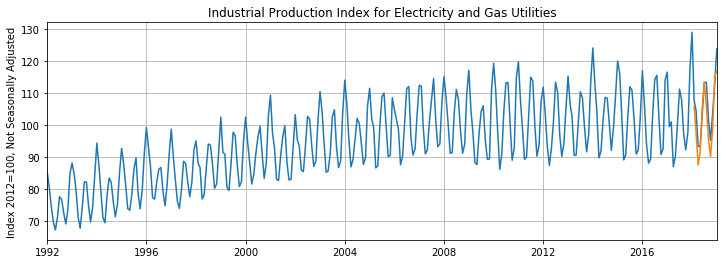

In [12]:
# DON'T WRITE HERE

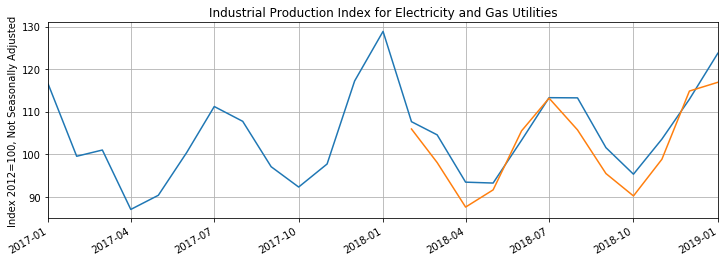

In [13]:
# DON'T WRITE HERE

## Great job!

<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# RNN Exercises - Solutions
For these exercises we're using data from the Federal Reserve Economic Database (FRED) concerning Electricity and Gas Utilities Production from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/IPG2211A2N

In the exercises below you'll be asked to do the following:
* Perform standard imports, load & plot the dataset (code provided)
* Prepare data for an LSTM model
* Define the LSTM model, loss and optimization functions
* Train the model
* Evaluate the model on test data
* OPTIONAL: Plot the results

<div class="alert alert-danger" style="margin: 10px"><strong>IMPORTANT NOTE!</strong> Make sure you don't run the cells directly above the example output shown, <br>otherwise you will end up writing over the example output!</div>

## Perform standard imports, load and plot the dataset
Run the cells below to load the libraries needed for this exercise and the Energy Production dataset, and to plot the data.

In [1]:
# RUN THIS CELL
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('../Data/TimeSeriesData/Energy_Production.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head()

325


,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


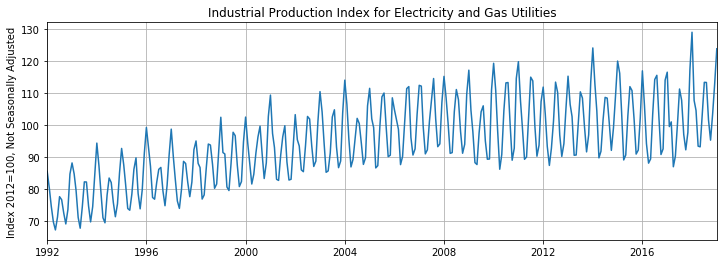

In [2]:
# RUN THIS CELL
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

# Prepare the data
For the first set of exercises we'll
* divide the data into train and test sets
* normalize the training set
* prepare windowed seq/label tuples for an LSTM model

## 1. Divide the data into train and test sets
Working with a window_size of 12, divide the dataset into a sequence of 313 training records (including the window), and a test set of 12 records.

In [ ]:
# CODE HERE
y = df['IPG2211A2N'].values.astype(float)

test_size = 
window_size = 

train_set = 
test_set = 

In [ ]:
# Run the code below to check your results:
print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

In [3]:
# DON'T WRITE HERE
y = df['IPG2211A2N'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 313
Test:  12


## 2. Normalize the training set
Feature scale the training set to fit within the range [-1,1].

In [ ]:
# CODE HERE
scaler = MinMaxScaler(feature_range=(-1, 1))


train_norm = 

In [ ]:
# Run the code below to check your results:
print(f'First item, original: {train_set[0]}')
print(f'First item, scaled:  {train_norm[0]}')

In [4]:
# DON'T WRITE HERE
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

print(f'First item, original: {train_set[0]}')
print(f'First item, scaled: {train_norm[0]}')

First item, original: 85.556
First item, scaled: [-0.4091274]


## 3. Prepare data for LSTM
Prepare the list of windowed sequence/label tuples to be fed into an LSTM model.

In [5]:
# RUN THIS CELL
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [ ]:
# CODE HERE

train_data = 

In [ ]:
# Run the code below to check your results:
print(f'Train_data: {len(train_data)}')  # should equal 301

In [6]:
# DON'T WRITE HERE
train_data = input_data(train_norm,window_size)

print(f'Train_data: {len(train_data)}')

Train_data: 301


## 4. Define the model
Design a model that has a (1,64) LSTM layer and a (64,1) fully-connected linear layer. Be sure to initialize $h_0$ and $c_0$, and return only the last predicted value.

In [ ]:
# CODE HERE
class LSTMnetwork(nn.Module):
    
    
    
    
    
    
    
    



In [ ]:
# Run the code below to check your results:
torch.manual_seed(101)
model = LSTMnetwork()
model

In [7]:
# DON'T WRITE HERE
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=64,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]
    
torch.manual_seed(101)
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

## 5. Define loss and optimization functions
Define a loss function called "criterion" and an optimizer called "optimizer".<br>
You can use any functions you want, although we used MSELoss and Adam (learning rate of 0.001) respectively.

In [ ]:
# CODE HERE




In [8]:
# DON'T WRITE HERE
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 6. Train the model
Don't worry about tracking loss values, displaying results, or validating the test set. Just train the model through 50 epochs. We'll evaluate the trained model in the next step.<br>
OPTIONAL: print something after each epoch to indicate training progress.

In [ ]:
# CODE HERE




In [9]:
# DON'T WRITE HERE
epochs = 50

for i in range(epochs):
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        # apply the model
        y_pred = model(seq)

        # update parameters
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # OPTIONAL print statement
    print(f'{i+1} of {epochs} epochs completed')

1 of 50 epochs completed
2 of 50 epochs completed
3 of 50 epochs completed
4 of 50 epochs completed
5 of 50 epochs completed
6 of 50 epochs completed
7 of 50 epochs completed
8 of 50 epochs completed
9 of 50 epochs completed
10 of 50 epochs completed
11 of 50 epochs completed
12 of 50 epochs completed
13 of 50 epochs completed
14 of 50 epochs completed
15 of 50 epochs completed
16 of 50 epochs completed
17 of 50 epochs completed
18 of 50 epochs completed
19 of 50 epochs completed
20 of 50 epochs completed
21 of 50 epochs completed
22 of 50 epochs completed
23 of 50 epochs completed
24 of 50 epochs completed
25 of 50 epochs completed
26 of 50 epochs completed
27 of 50 epochs completed
28 of 50 epochs completed
29 of 50 epochs completed
30 of 50 epochs completed
31 of 50 epochs completed
32 of 50 epochs completed
33 of 50 epochs completed
34 of 50 epochs completed
35 of 50 epochs completed
36 of 50 epochs completed
37 of 50 epochs completed
38 of 50 epochs completed
39 of 50 epochs compl

### 9. Evaluate the model using the test set
Be sure to re-initialize the hidden parameters $h_0$ and $c_0$ before running the model.

In [ ]:
# CODE HERE
future = 
preds = 

model.eval()

for i in range(future):




In [ ]:
# Run the code below to check your results:
preds[window_size:]

In [10]:
# DON'T WRITE HERE
future = 12
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())
        
preds[window_size:]

[0.25382155179977417,
 -0.0027704648673534393,
 -0.343053936958313,
 -0.21152164041996002,
 0.23945370316505432,
 0.4895053505897522,
 0.24688751995563507,
 -0.08669154345989227,
 -0.25793153047561646,
 0.022461334243416786,
 0.5438402891159058,
 0.6108715534210205]

## 10. Inverse transform the predicted values
Rescale the predicted values up to the original test set range.

In [ ]:
# CODE HERE
true_predictions = 

In [ ]:
# Run the code below to check your results:
true_predictions

In [11]:
# DON'T WRITE HERE
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[105.95129313],
       [ 98.05736803],
       [ 87.58871716],
       [ 91.63524249],
       [105.50927345],
       [113.20198736],
       [105.73797111],
       [ 95.47557801],
       [ 90.20746543],
       [ 98.83361172],
       [114.87357457],
       [116.93575791]])

## BONUS EXERCISE: Plot the result
Plot the true_predictions values together with the original data. Remember to create a range of datetime values for the predicted data.

In [ ]:
# CODE HERE


In [ ]:
# CODE HERE TO DISPLAY THE END OF THE GRAPH


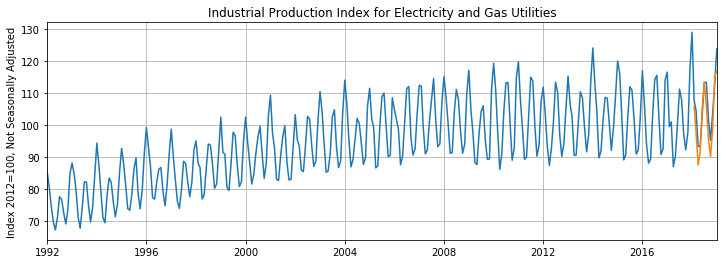

In [12]:
# DON'T WRITE HERE
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.show()

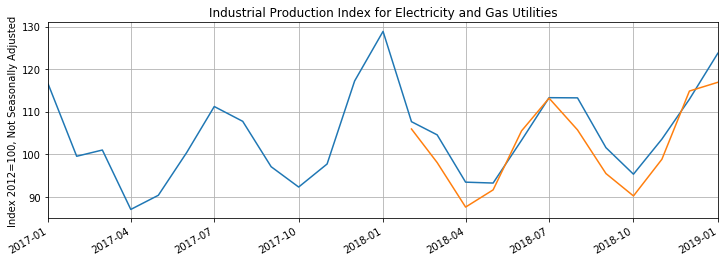

In [13]:
# DON'T WRITE HERE
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

## Great job!